# 06 - Edge-Planar Localization (Classical Dense CV)

Dieses Notebook nutzt einen **old-school CV Ansatz** auf einer planaren Szene:
- `map.png` und jeder Frame werden mit Kantenfilter verarbeitet
- Aus Train-Frames mit GT wird eine ungefaehre Hoehen-/Skalenbeziehung abgeleitet
- Val/Test Frames werden lokal in einem Crop um die letzte bekannte Position gegen die Edge-Map gematcht
- Optionaler Bewegungs-Prior via `phaseCorrelate` zwischen aufeinanderfolgenden Frames


## Idee (Planare Projektion)

Wenn die Kamera weitgehend nach unten schaut und Hoehe zwischen Frames aehnlich bleibt,
kann die Zuordnung Frame -> Karte lokal als skaliertes 2D-Matching auf der planaren map.png modelliert werden.
Kanten helfen, Farb-/Schatteneinfluesse zu reduzieren.


In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Paths (robust for running from project root or notebooks/)
CANDIDATE_ROOTS = [Path.cwd(), Path.cwd().parent, Path('.'), Path('..')]
PROJECT_ROOT = None
_seen_roots = set()
for cand in CANDIDATE_ROOTS:
    try:
        root = cand.resolve()
    except Exception:
        continue
    key = str(root)
    if key in _seen_roots:
        continue
    _seen_roots.add(key)
    if (root / 'data' / 'data').exists():
        PROJECT_ROOT = root
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError('Could not find project root containing data/data.')

DATA_ROOT = PROJECT_ROOT / 'data' / 'data'
TRAIN_IMG_DIR = DATA_ROOT / 'train_data' / 'train_images'
TEST_IMG_DIR = DATA_ROOT / 'test_data' / 'test_images'
TRAIN_POS_CSV = DATA_ROOT / 'train_data' / 'train_pos.csv'
TRAIN_CAM_CSV = DATA_ROOT / 'train_data' / 'train_cam.csv'
TEST_CAM_CSV = DATA_ROOT / 'test_data' / 'test_cam.csv'
MAP_PATH = DATA_ROOT / 'map.png'

# Split
SPLIT_SEED = 42
FIT_FRACTION = 0.8

# Runtime / preprocessing
IMAGE_MAX_SIDE = 1800  # set None for full resolution
EDGE_BLUR_KSIZE = 5
EDGE_CANNY_LOW = 60
EDGE_CANNY_HIGH = 170
MORPH_CLOSE_KERNEL = 3
MORPH_CLOSE_ITERS = 1

# Localization params
INIT_SEARCH_RADIUS_PX = 750
MIN_NCC = 0.28
SCALE_SEARCH_REL = [0.80, 0.90, 1.00, 1.10, 1.20]
ENABLE_PHASE_PRIOR = True
INIT_PHASE_MIN_RESP = 0.01

# Height/scale calibration controls
HEIGHT_CALIB_MAX_FRAMES = 40
HEIGHT_LOCAL_RADIUS = 900
HEIGHT_SCALE_CANDIDATES = [0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.22, 0.25, 0.28]
HEIGHT_MIN_NCC = 0.08

TEST_PRED_OUT = PROJECT_ROOT / 'build' / '06_edge_test_predictions.csv'

# Load CSV data
train_pos_df = pd.read_csv(TRAIN_POS_CSV)
train_cam_df = pd.read_csv(TRAIN_CAM_CSV)
test_cam_df = pd.read_csv(TEST_CAM_CSV)

train_df = train_cam_df.merge(train_pos_df, on='id', how='inner').copy()
train_df['id'] = train_df['id'].astype(int)
test_cam_df['id'] = test_cam_df['id'].astype(int)
train_df = train_df.sort_values('id').reset_index(drop=True)
test_cam_df = test_cam_df.sort_values('id').reset_index(drop=True)

map_bgr = cv2.imread(str(MAP_PATH), cv2.IMREAD_COLOR)
if map_bgr is None:
    raise FileNotFoundError(f'Map not found: {MAP_PATH}')
map_rgb = cv2.cvtColor(map_bgr, cv2.COLOR_BGR2RGB)
MAP_H, MAP_W = map_rgb.shape[:2]

print('project_root:', PROJECT_ROOT)
print('train:', len(train_df), 'test:', len(test_cam_df), 'map:', (MAP_W, MAP_H))


project_root: /home/rupert/projects/gnss-denied-localization
train: 305 test: 136 map: (5000, 2500)


In [3]:
# Train/validation split
rng = np.random.default_rng(SPLIT_SEED)
all_ids = train_df['id'].astype(int).unique().copy()
rng.shuffle(all_ids)

n_fit = max(1, min(len(all_ids) - 1, int(round(len(all_ids) * FIT_FRACTION))))
fit_ids = set(int(x) for x in all_ids[:n_fit])
val_ids = set(int(x) for x in all_ids[n_fit:])

fit_df = train_df[train_df['id'].isin(fit_ids)].copy().sort_values('id').reset_index(drop=True)
val_df = train_df[train_df['id'].isin(val_ids)].copy().sort_values('id').reset_index(drop=True)

print('fit:', len(fit_df), 'val:', len(val_df))


fit: 244 val: 61


In [4]:
# Helpers: IO, edge preprocessing, metric
_RGB_CACHE: Dict[Tuple[str, int, Optional[int]], np.ndarray] = {}
_EDGE_CACHE: Dict[Tuple[str, int, Optional[int], int, int, int, int], np.ndarray] = {}


def resolve_image_path(image_id: int, is_train: bool) -> Path:
    folder = TRAIN_IMG_DIR if is_train else TEST_IMG_DIR
    stems = [f'{int(image_id):04d}', str(int(image_id))]
    exts = ['.JPG', '.jpg', '.jpeg', '.JPEG', '.png', '.PNG']
    for st in stems:
        for ext in exts:
            p = folder / f'{st}{ext}'
            if p.exists():
                return p
    raise FileNotFoundError(f'Image not found: id={image_id} in {folder}')


def resize_keep_aspect(img: np.ndarray, max_side: Optional[int]) -> np.ndarray:
    if max_side is None:
        return img
    h, w = img.shape[:2]
    m = max(h, w)
    if m <= int(max_side):
        return img
    s = float(max_side) / float(m)
    nw = max(32, int(round(w * s)))
    nh = max(32, int(round(h * s)))
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)


def load_rgb_cached(image_id: int, split: str, max_side: Optional[int]) -> np.ndarray:
    key = (split, int(image_id), max_side)
    if key in _RGB_CACHE:
        return _RGB_CACHE[key]

    is_train = split in {'train', 'fit', 'val'}
    p = resolve_image_path(int(image_id), is_train=is_train)
    bgr = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if bgr is None:
        raise RuntimeError(f'Cannot read {p}')
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = resize_keep_aspect(rgb, max_side=max_side)
    _RGB_CACHE[key] = rgb
    return rgb


def edge_filter(rgb: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    k = int(max(1, EDGE_BLUR_KSIZE))
    if k % 2 == 0:
        k += 1
    if k > 1:
        gray = cv2.GaussianBlur(gray, (k, k), 0)
    edges = cv2.Canny(gray, int(EDGE_CANNY_LOW), int(EDGE_CANNY_HIGH))
    mk = int(max(1, MORPH_CLOSE_KERNEL))
    if mk > 1 and int(MORPH_CLOSE_ITERS) > 0:
        kernel = np.ones((mk, mk), dtype=np.uint8)
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=int(MORPH_CLOSE_ITERS))
    out = edges.astype(np.float32)
    out = cv2.normalize(out, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    return out


def get_edge_image(image_id: int, split: str) -> np.ndarray:
    key = (
        split,
        int(image_id),
        IMAGE_MAX_SIDE,
        int(EDGE_BLUR_KSIZE),
        int(EDGE_CANNY_LOW),
        int(EDGE_CANNY_HIGH),
        int(MORPH_CLOSE_KERNEL),
    )
    if key in _EDGE_CACHE:
        return _EDGE_CACHE[key]
    rgb = load_rgb_cached(int(image_id), split=split, max_side=IMAGE_MAX_SIDE)
    e = edge_filter(rgb)
    _EDGE_CACHE[key] = e
    return e


def extract_crop(img: np.ndarray, center_xy: Tuple[float, float], radius_px: int) -> Tuple[np.ndarray, int, int]:
    cx, cy = float(center_xy[0]), float(center_xy[1])
    r = int(max(32, radius_px))
    x0 = int(np.clip(round(cx) - r, 0, max(0, img.shape[1] - 1)))
    y0 = int(np.clip(round(cy) - r, 0, max(0, img.shape[0] - 1)))
    x1 = int(np.clip(round(cx) + r, 0, img.shape[1]))
    y1 = int(np.clip(round(cy) + r, 0, img.shape[0]))
    if x1 <= x0:
        x1 = min(img.shape[1], x0 + 1)
    if y1 <= y0:
        y1 = min(img.shape[0], y0 + 1)
    return img[y0:y1, x0:x1], x0, y0


def template_match_center(search_img: np.ndarray, template: np.ndarray) -> Tuple[float, float, float]:
    if template.shape[0] < 8 or template.shape[1] < 8:
        return np.nan, np.nan, -1.0
    if search_img.shape[0] < template.shape[0] or search_img.shape[1] < template.shape[1]:
        return np.nan, np.nan, -1.0
    res = cv2.matchTemplate(search_img, template, method=cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(res)
    cx = float(max_loc[0] + template.shape[1] * 0.5)
    cy = float(max_loc[1] + template.shape[0] * 0.5)
    return cx, cy, float(max_val)


def choose_processing_order(test_ids: List[int], min_known_train_id: int) -> List[int]:
    low = sorted([i for i in test_ids if i < int(min_known_train_id)], reverse=True)
    high = sorted([i for i in test_ids if i >= int(min_known_train_id)])
    return low + high


def eval_metric(pred_df: pd.DataFrame) -> Dict[str, float]:
    if len(pred_df) == 0:
        return {'n': 0.0, 'mean_err_px': np.nan, 'median_err_px': np.nan, 'acc_25': np.nan, 'acc_125': np.nan, 'acc_500': np.nan, 'score': np.nan}
    d = np.sqrt((pred_df['pred_x'] - pred_df['gt_x']) ** 2 + (pred_df['pred_y'] - pred_df['gt_y']) ** 2)
    a25 = float((d <= 25.0).mean())
    a125 = float((d <= 125.0).mean())
    a500 = float((d <= 500.0).mean())
    score = 100.0 * float(np.mean([a25, a125, a500]))
    return {
        'n': float(len(pred_df)),
        'mean_err_px': float(d.mean()),
        'median_err_px': float(d.median()),
        'acc_25': a25,
        'acc_125': a125,
        'acc_500': a500,
        'score': score,
    }


In [5]:
@dataclass
class HeightModel:
    rel_height_ref: float
    scale_ref: float
    scale_low: float
    scale_high: float
    search_radius_px: int


@dataclass
class MotionModel:
    B: np.ndarray  # [dx,dy,1] -> [dmap_x,dmap_y]
    phase_min_resp: float


def focal_from_row(row) -> float:
    fx = float(getattr(row, 'fx', np.nan))
    fy = float(getattr(row, 'fy', np.nan))
    if np.isfinite(fx) and np.isfinite(fy):
        return 0.5 * (fx + fy)
    if np.isfinite(fx):
        return fx
    if np.isfinite(fy):
        return fy
    return 1.0


def estimate_scale_at_gt(
    frame_edge: np.ndarray,
    gt_xy: Tuple[float, float],
    map_edge: np.ndarray,
    scale_candidates: List[float],
    local_radius: int = 950,
) -> Tuple[float, float]:
    best_s = np.nan
    best_ncc = -1.0
    for s in scale_candidates:
        tpl = cv2.resize(frame_edge, None, fx=float(s), fy=float(s), interpolation=cv2.INTER_AREA)
        if tpl.shape[0] < 8 or tpl.shape[1] < 8:
            continue
        r = max(int(local_radius), int(max(tpl.shape) * 1.3))
        crop, _, _ = extract_crop(map_edge, center_xy=gt_xy, radius_px=r)
        _, _, ncc = template_match_center(crop, tpl)
        if ncc > best_ncc:
            best_ncc = float(ncc)
            best_s = float(s)
    return float(best_s), float(best_ncc)


def derive_height_model(fit_subset: pd.DataFrame, map_edge: np.ndarray) -> Tuple[HeightModel, pd.DataFrame]:
    ids = fit_subset['id'].astype(int).tolist()
    max_frames = int(max(6, HEIGHT_CALIB_MAX_FRAMES))
    if len(ids) > max_frames:
        idx = np.linspace(0, len(ids) - 1, max_frames, dtype=int)
        ids = [ids[i] for i in idx]

    row_by_id = {int(r.id): r for r in fit_subset.itertuples(index=False)}
    scale_candidates = [float(x) for x in HEIGHT_SCALE_CANDIDATES]

    rows = []
    for qid in ids:
        r = row_by_id[int(qid)]
        gt_xy = (float(r.x_pixel), float(r.y_pixel))
        f = focal_from_row(r)
        q_edge = get_edge_image(int(qid), split='fit')
        best_s, best_ncc = estimate_scale_at_gt(q_edge, gt_xy, map_edge, scale_candidates=scale_candidates, local_radius=int(HEIGHT_LOCAL_RADIUS))
        if np.isfinite(best_s) and float(best_ncc) >= float(HEIGHT_MIN_NCC):
            rel_h = float(best_s * f)
            rows.append({'id': int(qid), 'focal': float(f), 'best_scale': float(best_s), 'best_ncc': float(best_ncc), 'rel_height': rel_h})

    diag = pd.DataFrame(rows)
    if len(diag) == 0:
        hm = HeightModel(rel_height_ref=0.18 * 1000.0, scale_ref=0.18, scale_low=0.12, scale_high=0.26, search_radius_px=INIT_SEARCH_RADIUS_PX)
        return hm, diag

    med_h = float(diag['rel_height'].median())
    mad_h = float(np.median(np.abs(diag['rel_height'].to_numpy() - med_h))) + 1e-6
    z = 0.6745 * (diag['rel_height'] - med_h) / mad_h
    inlier_mask = np.abs(z) <= 3.0
    diag['height_inlier'] = inlier_mask

    inl = diag[diag['height_inlier']].copy()
    if len(inl) < 6:
        inl = diag.copy()

    rel_height_ref = float(inl['rel_height'].median())
    scale_ref = float(inl['best_scale'].median())
    q1 = float(inl['best_scale'].quantile(0.25))
    q3 = float(inl['best_scale'].quantile(0.75))
    iqr = max(1e-4, q3 - q1)
    scale_low = max(0.05, q1 - 1.0 * iqr)
    scale_high = min(0.6, q3 + 1.0 * iqr)

    gt = fit_subset.sort_values('id')[['id', 'x_pixel', 'y_pixel']].copy()
    gt['dx'] = gt['x_pixel'].diff()
    gt['dy'] = gt['y_pixel'].diff()
    step = np.sqrt(gt['dx'] ** 2 + gt['dy'] ** 2).dropna()
    if len(step) > 0:
        sr = int(np.clip(np.percentile(step, 85) * 2.2 + 180, 350, 1600))
    else:
        sr = int(INIT_SEARCH_RADIUS_PX)

    hm = HeightModel(
        rel_height_ref=rel_height_ref,
        scale_ref=scale_ref,
        scale_low=float(scale_low),
        scale_high=float(scale_high),
        search_radius_px=int(sr),
    )
    return hm, diag


def derive_motion_model(fit_subset: pd.DataFrame) -> MotionModel:
    gt_by_id = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in fit_subset.itertuples(index=False)}
    ids = sorted(gt_by_id.keys())
    X, Y, responses = [], [], []

    for i in range(len(ids) - 1):
        a, b = ids[i], ids[i + 1]
        if b - a != 1:
            continue
        ea = get_edge_image(a, split='fit')
        eb = get_edge_image(b, split='fit')
        shift, resp = cv2.phaseCorrelate(ea.astype(np.float32), eb.astype(np.float32))
        dx, dy = float(shift[0]), float(shift[1])
        dmx = float(gt_by_id[b][0] - gt_by_id[a][0])
        dmy = float(gt_by_id[b][1] - gt_by_id[a][1])
        X.append([dx, dy, 1.0])
        Y.append([dmx, dmy])
        responses.append(float(resp))

    if len(X) < 6:
        B = np.zeros((3, 2), dtype=np.float64)
        min_resp = float(INIT_PHASE_MIN_RESP)
    else:
        Xn = np.asarray(X, dtype=np.float64)
        Yn = np.asarray(Y, dtype=np.float64)
        B, *_ = np.linalg.lstsq(Xn, Yn, rcond=None)
        med_resp = float(np.median(responses))
        min_resp = max(float(INIT_PHASE_MIN_RESP), 0.5 * med_resp)

    return MotionModel(B=B, phase_min_resp=float(min_resp))


In [6]:
# Global edge map + model derivation from train GT
map_edge = edge_filter(map_rgb)
height_model, height_diag = derive_height_model(fit_df, map_edge=map_edge)
motion_model = derive_motion_model(fit_df)

print('height_model:', height_model)
print('motion phase_min_resp:', motion_model.phase_min_resp)
if len(height_diag) > 0:
    print('height samples:', len(height_diag), 'inliers:', int(height_diag['height_inlier'].sum()))
else:
    print('height samples: 0')
display(height_diag.head(20))


height_model: HeightModel(rel_height_ref=603.1765068981972, scale_ref=0.09, scale_low=0.0899, scale_high=0.0901, search_radius_px=743)
motion phase_min_resp: 0.04875128576019663
height samples: 40 inliers: 34


,id,focal,best_scale,best_ncc,rel_height,height_inlier
0,13,6605.930072,0.09,0.167297,594.533706,False
1,21,6605.930072,0.09,0.221723,594.533706,False
2,32,6605.930072,0.09,0.173985,594.533706,False
3,40,6605.930072,0.11,0.176860,726.652308,False
4,57,6605.930072,0.09,0.157314,594.533706,False
5,71,6605.930072,0.11,0.177416,726.652308,False
6,2534,6701.961188,0.09,0.205998,603.176507,True
7,2541,6701.961188,0.09,0.143855,603.176507,True
8,2548,6701.961188,0.09,0.214806,603.176507,True
9,2557,6701.961188,0.09,0.173330,603.176507,True


In [7]:
# Localization core: anchor + local edge matching on map crop
all_train_gt = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in train_df.itertuples(index=False)}
fit_train_gt = {int(r.id): (float(r.x_pixel), float(r.y_pixel)) for r in fit_df.itertuples(index=False)}


def get_anchor_xy(image_id: int, known_xy: Dict[int, Tuple[float, float]]) -> Tuple[Tuple[float, float], int, str]:
    i = int(image_id)
    if (i - 1) in known_xy:
        return known_xy[i - 1], i - 1, 'prev_id'
    if (i + 1) in known_xy:
        return known_xy[i + 1], i + 1, 'next_id'
    if len(known_xy) > 0:
        nearest = min(known_xy.keys(), key=lambda k: abs(int(k) - i))
        return known_xy[nearest], int(nearest), f'nearest_id_{nearest}'
    return (MAP_W * 0.5, MAP_H * 0.5), -1, 'map_center'


def expected_scale_for_id(image_id: int, query_df: pd.DataFrame, hm: HeightModel) -> float:
    row = query_df[query_df['id'] == int(image_id)]
    if len(row) == 0:
        return float(hm.scale_ref)
    rr = next(row.itertuples(index=False))
    f = focal_from_row(rr)
    s = float(hm.rel_height_ref / max(1e-6, f))
    s = float(np.clip(s, hm.scale_low, hm.scale_high))
    return s


def motion_prior_from_anchor(
    q_edge: np.ndarray,
    anchor_id: int,
    anchor_xy: Tuple[float, float],
    processed_cache: Dict[int, np.ndarray],
    mm: MotionModel,
) -> Tuple[Tuple[float, float], float, bool]:
    if (not ENABLE_PHASE_PRIOR) or anchor_id < 0 or anchor_id not in processed_cache:
        return (float(anchor_xy[0]), float(anchor_xy[1])), 0.0, False
    a_edge = processed_cache[anchor_id]
    shift, resp = cv2.phaseCorrelate(a_edge.astype(np.float32), q_edge.astype(np.float32))
    dx, dy = float(shift[0]), float(shift[1])
    dm = np.array([dx, dy, 1.0], dtype=np.float64) @ mm.B
    pred = (float(anchor_xy[0] + dm[0]), float(anchor_xy[1] + dm[1]))
    pred = (float(np.clip(pred[0], 0, MAP_W - 1)), float(np.clip(pred[1], 0, MAP_H - 1)))
    ok = bool(float(resp) >= float(mm.phase_min_resp))
    return pred, float(resp), ok


def localize_near_anchor(
    q_edge: np.ndarray,
    coarse_xy: Tuple[float, float],
    map_edge: np.ndarray,
    expected_scale: float,
    hm: HeightModel,
    min_ncc: float,
) -> Tuple[Tuple[float, float], float, float, bool]:
    best = {'ncc': -1.0, 'pred_xy': (float(coarse_xy[0]), float(coarse_xy[1])), 'scale': float(expected_scale)}
    candidates = []
    for rel in SCALE_SEARCH_REL:
        s = float(expected_scale * float(rel))
        s = float(np.clip(s, hm.scale_low, hm.scale_high))
        candidates.append(s)
    candidates.append(float(hm.scale_ref))
    candidates = sorted(set(round(x, 5) for x in candidates))

    for s in candidates:
        tpl = cv2.resize(q_edge, None, fx=float(s), fy=float(s), interpolation=cv2.INTER_AREA)
        if tpl.shape[0] < 8 or tpl.shape[1] < 8:
            continue
        radius = max(int(hm.search_radius_px), int(max(tpl.shape) * 1.1))
        crop, x0, y0 = extract_crop(map_edge, center_xy=coarse_xy, radius_px=radius)
        cx, cy, ncc = template_match_center(crop, tpl)
        if np.isfinite(cx) and ncc > best['ncc']:
            px = float(np.clip(x0 + cx, 0, MAP_W - 1))
            py = float(np.clip(y0 + cy, 0, MAP_H - 1))
            best = {'ncc': float(ncc), 'pred_xy': (px, py), 'scale': float(s)}

    if best['ncc'] < float(min_ncc):
        return (float(coarse_xy[0]), float(coarse_xy[1])), float(best['ncc']), float(best['scale']), False
    return best['pred_xy'], float(best['ncc']), float(best['scale']), True


def run_localization(
    query_df: pd.DataFrame,
    split_name: str,
    known_xy_init: Dict[int, Tuple[float, float]],
    hm: HeightModel,
    mm: MotionModel,
    reverse_prefix_from_train13: bool = False,
) -> pd.DataFrame:
    known_xy = dict(known_xy_init)
    processed_cache: Dict[int, np.ndarray] = {}

    ids = query_df['id'].astype(int).tolist()
    if split_name == 'test' and reverse_prefix_from_train13:
        min_train_id = int(train_df['id'].min())
        order = choose_processing_order(ids, min_known_train_id=min_train_id)
    else:
        order = sorted(ids)

    gt_by_id = {}
    if 'x_pixel' in query_df.columns and 'y_pixel' in query_df.columns:
        for r in query_df.itertuples(index=False):
            gt_by_id[int(r.id)] = (float(r.x_pixel), float(r.y_pixel))

    rows = []
    for k, qid in enumerate(order, 1):
        split_for_img = 'val' if split_name == 'val' else ('fit' if split_name == 'fit' else 'test')
        q_edge = get_edge_image(int(qid), split=split_for_img)

        anchor_xy, anchor_id, anchor_src = get_anchor_xy(int(qid), known_xy)
        coarse_xy, phase_resp, phase_ok = motion_prior_from_anchor(
            q_edge=q_edge,
            anchor_id=anchor_id,
            anchor_xy=anchor_xy,
            processed_cache=processed_cache,
            mm=mm,
        )
        if not phase_ok:
            coarse_xy = (float(anchor_xy[0]), float(anchor_xy[1]))

        s_exp = expected_scale_for_id(int(qid), query_df=query_df, hm=hm)
        pred_xy, ncc, s_used, used_tm = localize_near_anchor(
            q_edge=q_edge,
            coarse_xy=coarse_xy,
            map_edge=map_edge,
            expected_scale=s_exp,
            hm=hm,
            min_ncc=float(MIN_NCC),
        )

        known_xy[int(qid)] = pred_xy
        processed_cache[int(qid)] = q_edge

        gt = gt_by_id.get(int(qid), (np.nan, np.nan))
        err = np.nan if np.isnan(gt[0]) else float(np.hypot(pred_xy[0] - gt[0], pred_xy[1] - gt[1]))

        rows.append({
            'id': int(qid),
            'pred_x': float(pred_xy[0]),
            'pred_y': float(pred_xy[1]),
            'gt_x': float(gt[0]),
            'gt_y': float(gt[1]),
            'err_px': err,
            'anchor_source': anchor_src,
            'anchor_id': int(anchor_id),
            'phase_resp': float(phase_resp),
            'used_phase': bool(phase_ok),
            'expected_scale': float(s_exp),
            'used_scale': float(s_used),
            'tm_ncc': float(ncc),
            'used_template': bool(used_tm),
        })

        if k % 10 == 0:
            print(f'[{split_name}] done {k}/{len(order)}')

    return pd.DataFrame(rows).sort_values('id').reset_index(drop=True)


In [8]:
# Validation inference
val_pred_df = run_localization(
    query_df=val_df,
    split_name='val',
    known_xy_init=fit_train_gt,
    hm=height_model,
    mm=motion_model,
    reverse_prefix_from_train13=False,
)

val_metrics = eval_metric(val_pred_df.dropna(subset=['gt_x', 'gt_y']))
print(pd.Series(val_metrics))
display(val_pred_df.head(20))


[val] done 10/61
[val] done 20/61
[val] done 30/61
[val] done 40/61
[val] done 50/61
[val] done 60/61
n                 61.000000
mean_err_px      205.150919
median_err_px     87.293982
acc_25             0.000000
acc_125            0.606557
acc_500            0.901639
score             50.273224
dtype: float64


,id,pred_x,pred_y,gt_x,gt_y,err_px,anchor_source,anchor_id,phase_resp,used_phase,expected_scale,used_scale,tm_ncc,used_template
0,14,2572.737997,286.932310,2584.838216,569.575778,282.902360,prev_id,13,0.000000,False,0.0901,0.0899,0.147604,False
1,19,2628.009666,1698.616847,2310.170891,1888.884916,370.436804,prev_id,18,0.000000,False,0.0901,0.0899,0.143373,False
2,23,2278.064229,1032.964801,2267.377316,751.323745,281.843741,prev_id,22,0.000000,False,0.0901,0.0900,0.182845,False
3,27,1934.452421,602.216375,1944.109308,881.632099,279.582550,prev_id,26,0.000000,False,0.0901,0.0899,0.173469,False
4,28,1934.452421,602.216375,1954.878894,1165.583698,563.737511,prev_id,27,-0.000841,False,0.0901,0.0900,0.196126,False
5,29,1934.452421,602.216375,1965.704955,1447.604773,845.965876,prev_id,28,-0.000054,False,0.0901,0.0899,0.204658,False
6,30,1934.452421,602.216375,1977.600712,1726.207573,1124.819091,prev_id,29,0.003309,False,0.0901,0.0901,0.192950,False
7,35,1629.333663,1050.784934,1617.589353,768.682623,282.346671,prev_id,34,0.000000,False,0.0901,0.0900,0.168958,False
8,36,1629.333663,1050.784934,1606.662369,487.115857,564.124823,prev_id,35,0.005993,False,0.0901,0.0901,0.224555,False
9,47,2364.858860,611.947642,2082.553379,623.067009,282.524379,prev_id,46,0.000000,False,0.0901,0.0899,0.180218,False


In [9]:
# Optional test inference (no GT)
test_pred_df = run_localization(
    query_df=test_cam_df,
    split_name='test',
    known_xy_init=all_train_gt,
    hm=height_model,
    mm=motion_model,
    reverse_prefix_from_train13=True,
)

test_out = test_pred_df[['id', 'pred_x', 'pred_y']].rename(columns={'pred_x': 'x_pixel', 'pred_y': 'y_pixel'})
test_out = test_out.sort_values('id').reset_index(drop=True)
TEST_PRED_OUT.parent.mkdir(parents=True, exist_ok=True)
test_out.to_csv(TEST_PRED_OUT, index=False)
print('written:', TEST_PRED_OUT, 'rows:', len(test_out))
display(test_out.head())


[test] done 10/136
[test] done 20/136
[test] done 30/136
[test] done 40/136
[test] done 50/136
[test] done 60/136
[test] done 70/136
[test] done 80/136
[test] done 90/136
[test] done 100/136
[test] done 110/136
[test] done 120/136
[test] done 130/136
written: /home/rupert/projects/gnss-denied-localization/build/06_edge_test_predictions.csv rows: 136


,id,x_pixel,y_pixel
0,1,2572.737997,286.93231
1,2,2572.737997,286.93231
2,3,2572.737997,286.93231
3,4,2572.737997,286.93231
4,5,2572.737997,286.93231


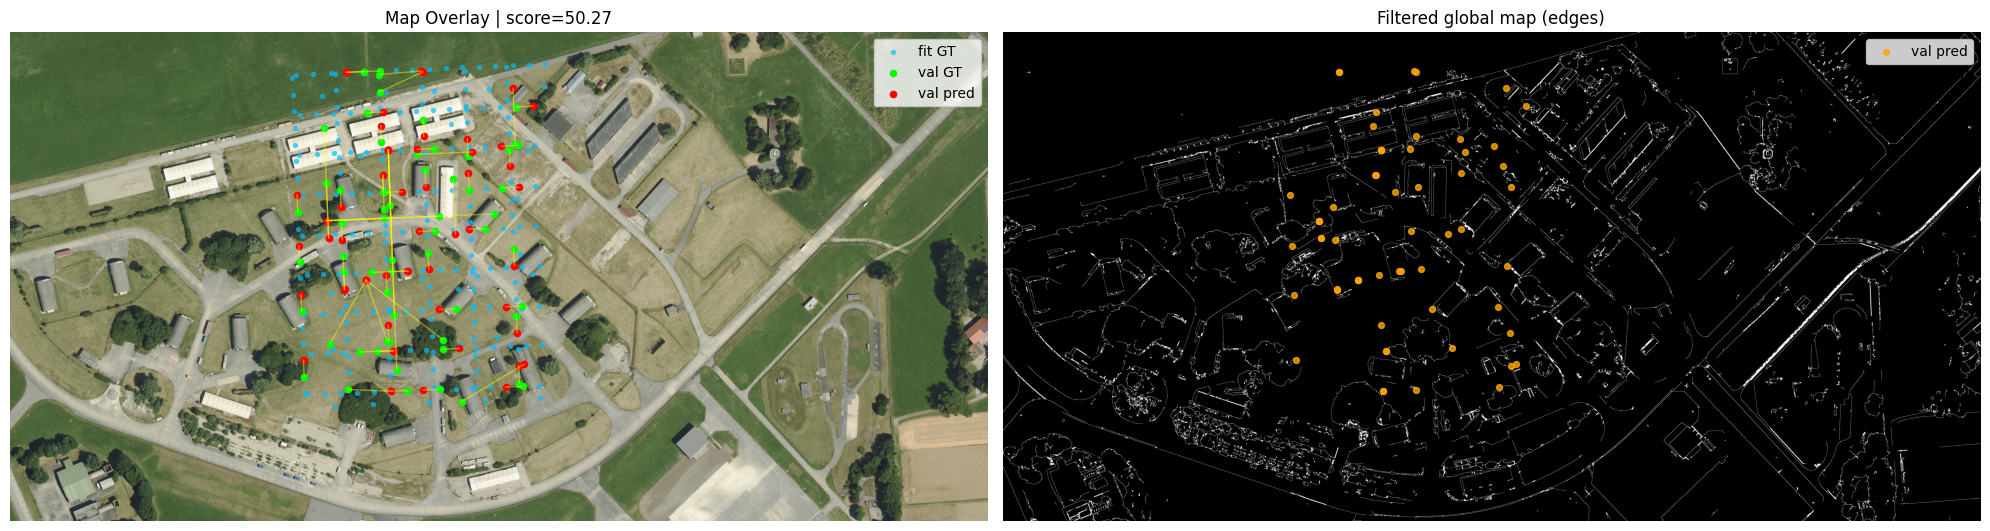

In [10]:
# Visualization on map.png and diagnostic edge map
fit_xy = fit_df[['x_pixel', 'y_pixel']].to_numpy(dtype=np.float32)
v = val_pred_df.dropna(subset=['gt_x', 'gt_y']).copy()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(map_rgb)
if len(fit_xy) > 0:
    axes[0].scatter(fit_xy[:, 0], fit_xy[:, 1], s=8, c='deepskyblue', alpha=0.6, label='fit GT')
if len(v) > 0:
    for r in v.itertuples(index=False):
        axes[0].plot([r.pred_x, r.gt_x], [r.pred_y, r.gt_y], color='yellow', alpha=0.45, linewidth=1.0)
    axes[0].scatter(v['gt_x'], v['gt_y'], s=20, c='lime', label='val GT')
    axes[0].scatter(v['pred_x'], v['pred_y'], s=20, c='red', label='val pred')
axes[0].set_title(f"Map Overlay | score={val_metrics['score']:.2f}")
axes[0].legend(loc='upper right')
axes[0].axis('off')

axes[1].imshow(map_edge, cmap='gray')
if len(v) > 0:
    axes[1].scatter(v['pred_x'], v['pred_y'], s=18, c='orange', alpha=0.8, label='val pred')
axes[1].set_title('Filtered global map (edges)')
axes[1].legend(loc='upper right')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Diagnostics
print('Anchor sources (val):')
print(val_pred_df['anchor_source'].value_counts(dropna=False))

print('Template usage (val):')
print(val_pred_df['used_template'].value_counts(dropna=False))

print('Phase usage (val):')
print(val_pred_df['used_phase'].value_counts(dropna=False))

display(val_pred_df[['id', 'err_px', 'expected_scale', 'used_scale', 'tm_ncc', 'phase_resp', 'used_template', 'anchor_source']].head(40))


Anchor sources (val):
anchor_source
prev_id    60
next_id     1
Name: count, dtype: int64
Template usage (val):
used_template
False    61
Name: count, dtype: int64
Phase usage (val):
used_phase
False    55
True      6
Name: count, dtype: int64


,id,err_px,expected_scale,used_scale,tm_ncc,phase_resp,used_template,anchor_source
0,14,282.902360,0.0901,0.0899,0.147604,0.000000,False,prev_id
1,19,370.436804,0.0901,0.0899,0.143373,0.000000,False,prev_id
2,23,281.843741,0.0901,0.0900,0.182845,0.000000,False,prev_id
3,27,279.582550,0.0901,0.0899,0.173469,0.000000,False,prev_id
4,28,563.737511,0.0901,0.0900,0.196126,-0.000841,False,prev_id
5,29,845.965876,0.0901,0.0899,0.204658,-0.000054,False,prev_id
6,30,1124.819091,0.0901,0.0901,0.192950,0.003309,False,prev_id
7,35,282.346671,0.0901,0.0900,0.168958,0.000000,False,prev_id
8,36,564.124823,0.0901,0.0901,0.224555,0.005993,False,prev_id
9,47,282.524379,0.0901,0.0899,0.180218,0.000000,False,prev_id
